In [49]:
# 1️⃣ Import Library yang Diperlukan
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

In [50]:
# 2️⃣ Konfigurasi Dataset & Parameter
DATASET_PATH = r"D:\Skripsi\sc\dataset_split"   # Sesuaikan dengan path dataset Anda
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [51]:
# 3️⃣ Definisikan Pipeline Augmentasi Data (Hanya untuk training)
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2)
], name="data_augmentation")

In [52]:
# 4️⃣ Memuat Dataset Training menggunakan image_dataset_from_directory
dataset_train = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 5208 files belonging to 31 classes.


In [53]:
# 5️⃣ Memuat Dataset Validasi
dataset_val = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 1302 files belonging to 31 classes.


In [54]:
# 6️⃣ Ambil Informasi Jumlah Kelas
num_classes = len(dataset_train.class_names)
print(f"Jumlah kelas: {num_classes}")

Jumlah kelas: 31


In [55]:
# 7️⃣ Terapkan Augmentasi dan Preprocessing
# Preprocessing dilakukan dengan fungsi preprocess_input sesuai model EfficientNetV2-S
# Augmentasi hanya diterapkan pada dataset training
dataset_train = dataset_train.map(
    lambda x, y: (data_augmentation(preprocess_input(x), training=True), y),
    num_parallel_calls=AUTOTUNE
)
dataset_val = dataset_val.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)

In [56]:
# 8️⃣ Optimasi Performa dengan Prefetch
dataset_train = dataset_train.prefetch(AUTOTUNE)
dataset_val = dataset_val.prefetch(AUTOTUNE)

In [57]:
# 9️⃣ Memuat Base Model EfficientNetV2-S dengan Pretrained Weights dari ImageNet
base_model = EfficientNetV2S(input_shape=(224, 224, 3), include_top=False, weights="imagenet")


In [58]:
# 10️⃣ Fine-tuning: Aktifkan Pelatihan pada Base Model
# Anda juga bisa memilih untuk hanya membuka beberapa lapisan teratas saja.
base_model.trainable = True

# Opsional: untuk fine-tuning bertahap, kita bisa freeze sebagian lapisan awal. Misalnya:
# for layer in base_model.layers[:-50]:
#     layer.trainable = False

In [59]:
# 11️⃣ Membangun Model Lengkap Menggunakan Functional API
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)   # Pastikan forward pass dijalankan dalam mode training
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [60]:
# 12️⃣ Compile Model dengan Optimizer Adam dan Learning Rate 0.0005
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [61]:
# 13️⃣ Training Model Selama 30 Epoch
history = model.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=15
)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 1619s 9s/step - accuracy: 0.4949 - loss: 1.9066 - val_accuracy: 0.8602 - val_loss: 0.4639
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 1512s 9s/step - accuracy: 0.8318 - loss: 0.5634 - val_accuracy: 0.8879 - val_loss: 0.4411
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 1503s 9s/step - accuracy: 0.8778 - loss: 0.4174 - val_accuracy: 0.9048 - val_loss: 0.3350
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 1527s 9s/step - accuracy: 0.9003 - loss: 0.3151 - val_accuracy: 0.9040 - val_loss: 0.3400
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 1505s 9s/step - accuracy: 0.9263 - loss: 0.2688 - val_accuracy: 0.8994 - val_loss: 0.3471
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 1496s 9s/step - accuracy: 0.9293 - loss: 0.2474 - val_accuracy: 0.9094 - val_loss: 0.3128
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 1389s 9s/step - accuracy: 0.9349 - loss: 0.2172 - val_accuracy: 0.9278 - val_loss: 0.2649
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 1397s 8s/step - accuracy: 0.9350 - loss: 0.1944 - 

In [62]:
# 14️⃣ Simpan Model dalam Format .keras
model.save("D:\Skripsi\scv2\models\efficientnetv2_rempahindo.keras")
print("✅ Model telah disimpan!")

✅ Model telah disimpan!


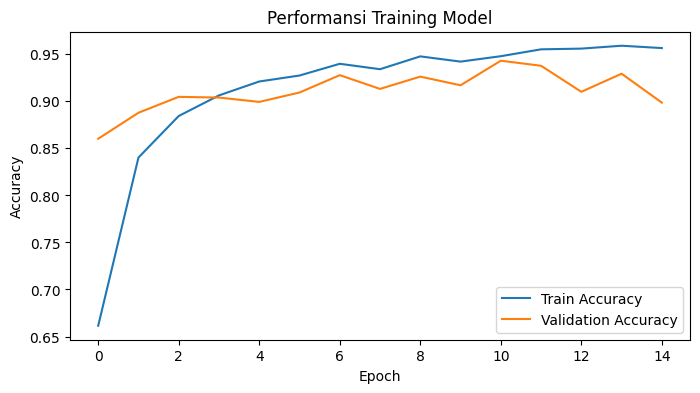

In [63]:
# 15️⃣ Visualisasi Grafik Akurasi Training dan Validasi
plt.figure(figsize=(8, 4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Performansi Training Model")
plt.show()